# Import needed modules and useful functions

In [1]:
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':500000, # 500000 2.5ns ,10000000 -> 50ns of simulation
    'plumedseed':4525,
    'friction':10,
    'temp':1, # kbt units, 1 ok
    'initial_position':[1.27],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias/bias1_tica/"
#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"],dim=1)
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")

#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias/bias1_tica/
Completed: plumed ves_md_linearexpansion input


## Trajectory 

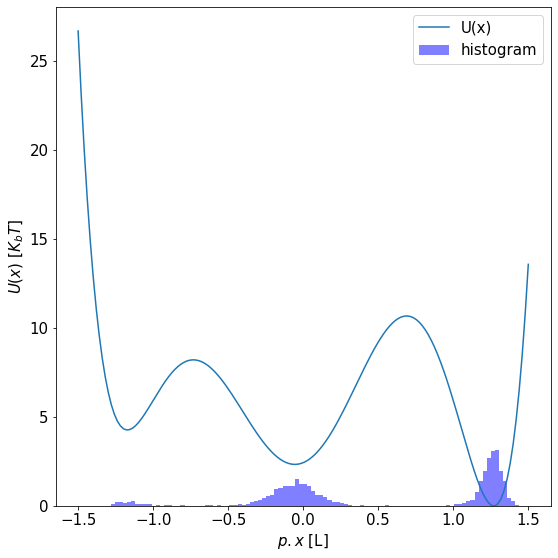

In [5]:
data = load_dataframe(folder+"COLVAR")
fig, ax = plt.subplots(figsize=(8,8))

x = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values
ax.hist(x,bins=100,color="blue",alpha=0.5,label="Trajectory",density=True)

xx = np.linspace(-1.5,1.5,150)
y =  potential1d_function(xx)
y-=np.min(y)

ax.plot(xx,y)
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$U(x)$ [$K_b T$]")

ax.legend([r"U(x)","histogram"])

plt.tight_layout()

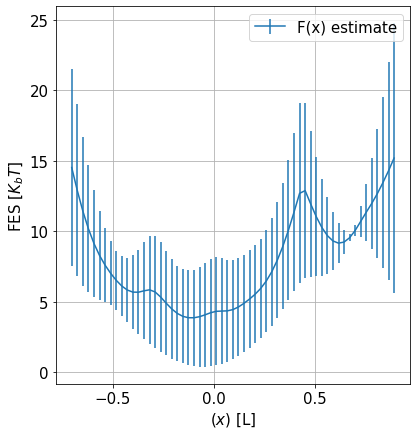

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= data["opes.bias"].to_numpy()/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))

fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x)$ [L]")
ax.set_ylabel(r"FES [$K_b T$]")

plt.show()

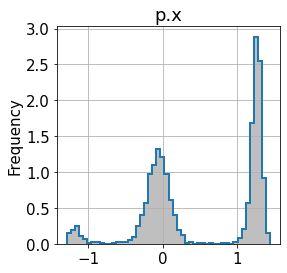

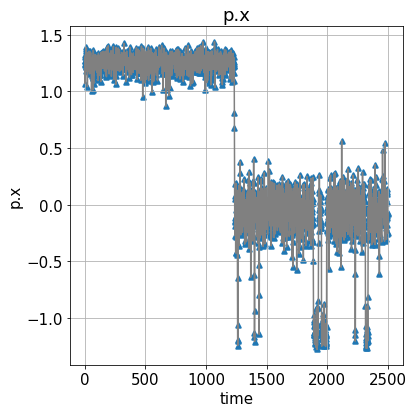

In [9]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,ax = plt.subplots(1,1,figsize=(4,4),sharey=True)

data["p.x"].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
data["p.x"].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
ax.set_title("p.x")

fig,ax = plt.subplots(1,1,figsize=(6,6))

data[::1].plot.scatter(x="time",y="p.x",alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
data[::1].plot.line(x="time",y="p.x",alpha=1,ax=ax,legend=False,grid=True,color="grey")
ax.set_title("p.x")

plt.tight_layout()

## DeepTICA Analysis and Export

In [10]:
data = load_dataframe(folder+"COLVAR")
size = len(data)
min_lag,max_lag = 1,1 
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^p').columns.values

#-- TRAINING PARAMETERS --#
n_output = 3
n_input = len(descriptors_names)
train_parameters = {
              'descriptors': '^p', # can change during simulation
              'nodes':[n_input,10,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.8, 
              'lrate':1e-4,
              'l2_reg':0,
              'num_epochs':500,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':100,
              }
#--------------------------------------#

print(train_parameters["nodes"])

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values
print(X.shape)

[1.]
[1, 10, 3]
training samples:  2000 	 validation samples 490
(2501, 1)


In [11]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=lag,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
print(model.tica.symmetrize)
#model.tica.symmetrize = False
print(model.tica.symmetrize)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.0,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

True
True
Epoch Train Loss  Valid Loss  Eigenvalues             
100   -1.876      -1.896      0.983  0.882  0.010  
INFO: Early stopping
152   -1.895      -1.913      0.982  0.904  0.007  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

## DeepTICA Analysis and Export

In [12]:
#-- move the model back to cpu for convenience --# 
model.to('cpu')

model.tica.timescales(train_parameters["lag_time"])
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

torch.float32
torch.float32
timescales:  [541.1428     99.20076     2.0064883]
eigenvalues:  [0.9816903  0.9041087  0.00684777]


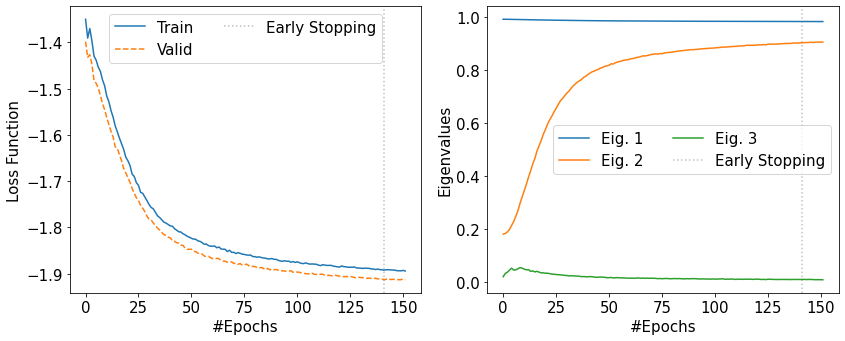

In [13]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [14]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

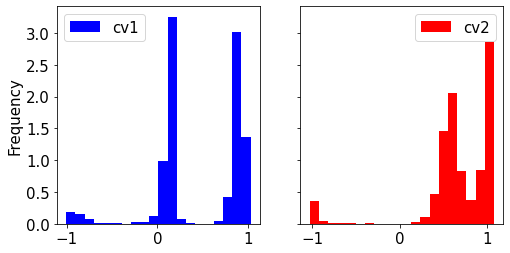

In [15]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

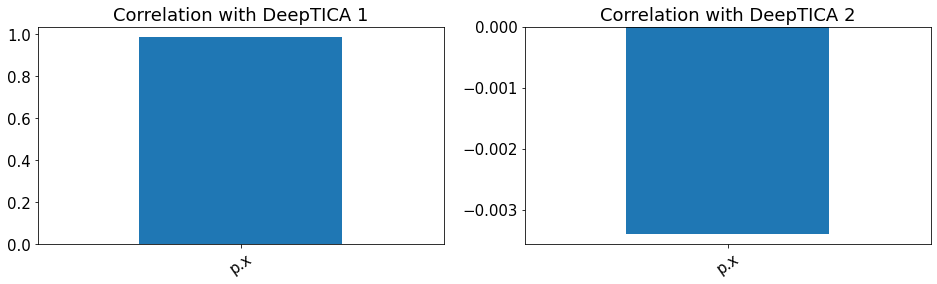

In [16]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from new cvs  

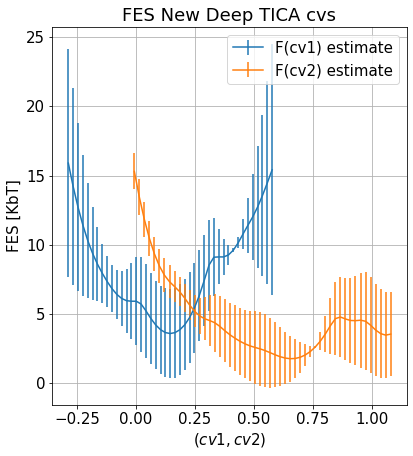

In [17]:
#-- estimation of Free Energy Surface --#
logweight=data["opes.bias"].to_numpy()/sim_parameters["temp"]
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

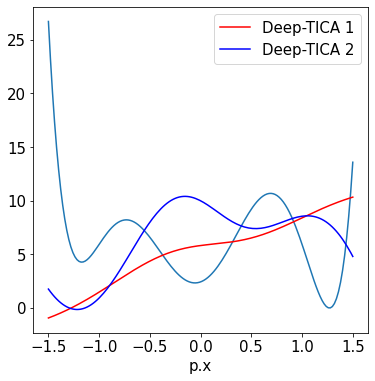

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
xx = np.linspace(-1.5,1.5,150).reshape(150,1)
# potential energy
y =  potential1d_function(xx)
y-=np.min(y)
ax.plot(xx,y)
# first cv
y = np.transpose(model(torch.Tensor(xx)).detach().cpu().numpy())[0]*5+5
#y -= np.min(y)
ax.plot(xx,y,color="red",label="Deep-TICA 1")

# second cv
y = np.transpose(model(torch.Tensor(xx)).detach().cpu().numpy())[1]*5+5
#y -= np.min(y)
ax.plot(xx,y,color="blue",label="Deep-TICA 2")

ax.set_xlabel("p.x")
ax.legend()

# TICA

In [21]:
data = load_dataframe(folder+"COLVAR")
t = data['time'].values
X = data[descriptors_names].values

# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)

TICA_CV()

In [22]:
# TRAIN
tica.fit(X, t, lag=min_lag)

#-- move the model back to cpu for convenience --# 
tica.to('cpu')
feature_names = data.filter(regex="p.*").columns.values
tica.set_params({"feature_names": feature_names})
#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

eigenvalues:  [0.97325504]


In [23]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]

<AxesSubplot:ylabel='Frequency'>

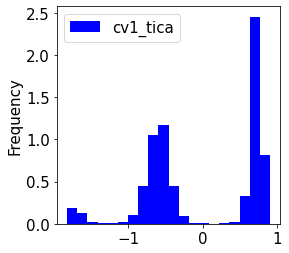

In [26]:
fig,axs = plt.subplots(1,1,figsize=(4,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs,density=True,color="b")

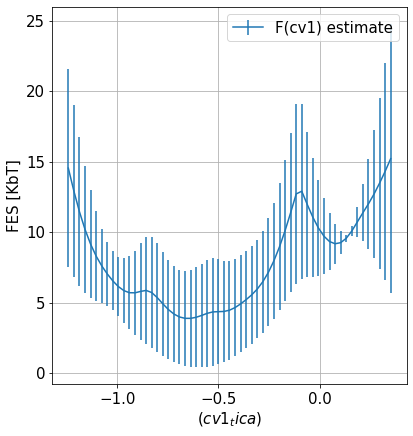

In [27]:
#-- estimation of Free Energy Surface --#
s = data["cv1_tica"].to_numpy()
logweight=data["opes.bias"].to_numpy()/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))

fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1_tica)$")
ax.set_ylabel("FES [KbT]")

plt.show()

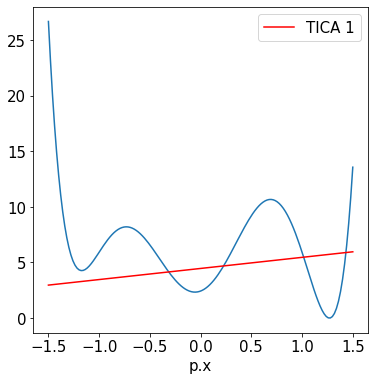

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
xx = np.linspace(-1.5,1.5,150).reshape(150,1)
# potential energy
y =  potential1d_function(xx)
y-=np.min(y)
ax.plot(xx,y)
# first cv
y = np.transpose(tica(torch.Tensor(xx)).detach().cpu().numpy())[0]+5
#y -= np.min(y)
ax.plot(xx,y,color="red",label="TICA 1")

ax.set_xlabel("p.x")
ax.legend()